# Image Generation with OpenVINO GenAI

## Install dependencies

In [ ]:
!pip install openvino-genai optimum-intel nncf huggingface diffusers accelerate --extra-index-url https://download.pytorch.org/whl/cpu

## Query devices

In [2]:
import openvino as ov

core = ov.Core()
available_devices = core.available_devices

print(available_devices)
print([core.get_property(device, "FULL_DEVICE_NAME") for device in available_devices])

['CPU', 'GPU', 'NPU']
['Intel(R) Core(TM) Ultra 7 258V', 'Intel(R) Arc(TM) Graphics (iGPU)', 'Intel(R) AI Boost']


In [3]:
device = 'GPU'

## Download and run a text-to-image pipeline from Hugging Face

In [4]:
from optimum.exporters.openvino.convert import export_tokenizer

from optimum.intel import OVPipelineForText2Image

lcm_output_dir = "models/dreamshaper-v7-lcm"
model_id = "SimianLuo/LCM_Dreamshaper_v7"

pipeline = OVPipelineForText2Image.from_pretrained(model_id, export=True, device=device)

pipeline.save_pretrained(lcm_output_dir)
export_tokenizer(pipeline.tokenizer, lcm_output_dir + "/tokenizer")

Multiple distributions found for package optimum. Picked distribution: optimum
/home/adrian/repos/openvino_build_deploy/trainings/image_generation/venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/adrian/repos/openvino_build_deploy/trainings/image_generation/venv/lib/python3.13/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
Keyword arguments {'subfolder': '', 'trust_remote_code': False} are not expected by LatentConsistencyModelPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/home/adrian/repos/openvino_build_deploy/trainings/image_generation/venv/lib/python3.13/site-packages/transformers/models/clip/modeling_clip.py:237: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if seq_length > max_position_embedding:
/home/adrian/repos/openvino_build_deploy/trainings/image_generation/venv/lib/python3.13/site-packages/transformers/modeling_attn_mask_utils.py:94: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or

In [ ]:
prompt = "sailing ship in storm by Leonardo da Vinci"

image = pipeline(prompt, num_inference_steps=4, guidance_scale=8.0).images[0]
image

  0%|          | 0/4 [00:00<?, ?it/s]

### Run text-to-image using OpenVINO Gen-AI pipeline

In [1]:
import openvino_genai as ov_genai

lcm_pipe = ov_genai.Text2ImagePipeline(lcm_output_dir, device)

NameError: name 'lcm_output_dir' is not defined

In [ ]:
import numpy as np
from PIL import Image

prompt = "Cartoon-style adventurer child with a backpack and a treasure map"

steps = 8
seed = np.random.randint(2**31)

image_tensor = lcm_pipe.generate(prompt, rng_seed=seed, width=768, height=768, num_inference_steps=steps, num_images_per_prompt=1)

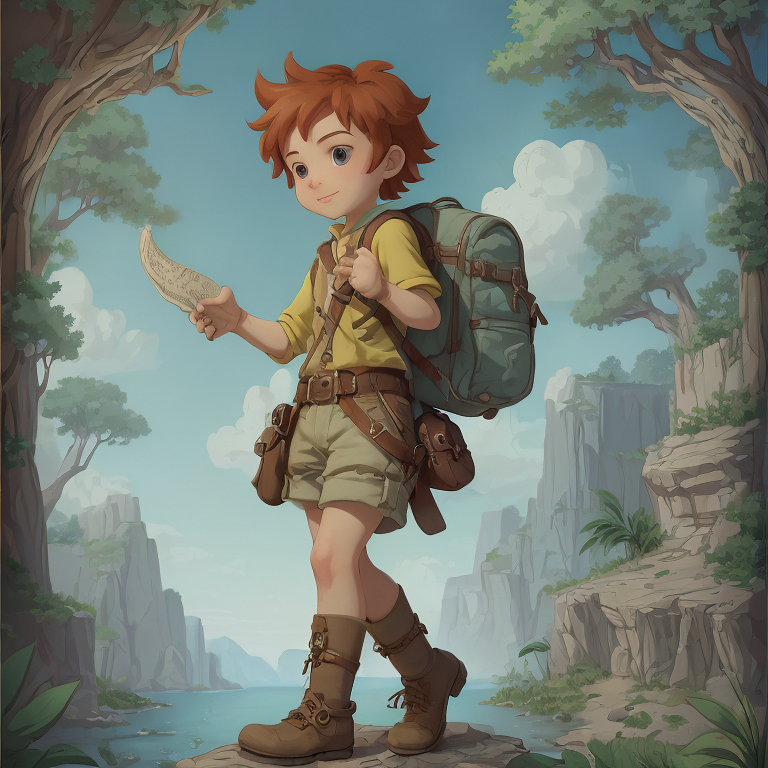

In [10]:
image = Image.fromarray(image_tensor.data[0])
image

In [11]:
print(f"Inference time: {lcm_pipe.get_performance_metrics().get_inference_duration():.2f} ms")
print(f"{steps} steps, one step time: {lcm_pipe.get_performance_metrics().get_iteration_duration().mean:.2f} ms")

Inference time: 23551.34 ms
8 steps, one step time: 2621.33 ms
